# SWiFT Multifile
Demonstration of some of the mmctools functions and standards for postprocessing WRF-LES output <br>
Also includes examples of MMC spectra and correlation lengthscale functions.

#############################################################################

## Preamble
Set file paths, enter physical constants, import modules, etc...

### Import modules

In [1]:
import glob
import os, re

# Well-known python modules (i.e, available through conda)

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import glob
import os
import sys

# Less well-known

import wrf #as wrf

module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)
import mmctools

### Physical constants and other parameters

In [2]:
g = 9.81 #[m/s/s], gravitational constant

### User-defined functions

In [3]:
########################
# Postprocess WRF output
########################
#
#
#    The purpose of this function is to take the DataSet that is produced from an xarray 'open_mfdataset'
#         function call and to modify it to work well with mmctools functions. This includes:
#               -Renaming dimensions and coordinates to code standards
#               -Computing 1-D Z [m] variable and assigning it as a coordinate
#               -Destaggering winds
#               -Returns only the requested variables (optional)
#               -Truncates the simulation output at some height (optional)

def postprocess_wrf_outout( ds, variable_list = ['U', 'V', 'W', 'T', 'UST'], z_max = None ):
    '''
    Changes coordinate, dimension, and variable names, computes z, destaggers wind fields.
        ds: Xarray Dataset. Default from open_mfdataset on all WRF variables
        
            
        z_max: maximum z (float). If defined, any model output above this height will be truncated. Default is None.
    '''
    
    # Rename dims, and drop XLAT/XLONG coords (since they're all 0 for an idealized run)
    print("Renaming dims...")
    ds = ds.rename_dims( {'west_east': 'nx', 'south_north': 'ny', 'bottom_top': 'nz',
                'west_east_stag': 'nx_stag', 'south_north_stag': 'ny_stag', 'bottom_top_stag': 'nz_stag'})

    ds = ds.drop(['XLAT','XLONG','XLAT_U','XLONG_U','XLAT_V','XLONG_V'])
    
    # Compute x, y, and z. Assign as coords.
    print("Computing x, and y...")
    ds['x'] = ds.nx * ds.DX
    ds['y'] = ds.ny * ds.DY

    print('...and now z...')

    ds['z_stag_4D'] = ( ds.PH + ds.PHB) / g
    ds['z_stag_1D'] = ds.z_stag_4D.mean(dim = ('nx', 'ny', 'Time') )
    z1D = (ds.z_stag_1D.values[:-1] + \
           ds.z_stag_1D.values[1:] ) / 2.
    ds['z1D'] = xr.DataArray( z1D, dims = 'nz' )

    print("Assigning coords...")
    ds  =  ds.assign_coords({'x': ds.x, 'y': ds.y, 'z': ds.z1D})
    
    # Truncate above z_max
    if z_max is not None:
        print(f"z_max is defined, truncating above {z_max} m")
        z_ind = np.where( ds.z1D > z_max )
        #print(z_ind)
        if len(z_ind) == 0:
            print(f"z_max = {z_max} is higher than model top")
            print("continuing")
        else:
            z_ind = z_ind[0][0]
            #print(z_ind)
            ds = ds.isel(nz = slice(0,z_ind + 1), nz_stag =slice(0,z_ind + 2) )
            print(f"Grid cells above {z_max} discarded")
    
    else:
        print("z_max is none, processing entire domain")
        
    print("destaggering winds...")
    ds = ds.rename({'U': 'U_stag', 'V': 'V_stag', 'W': 'W_stag'})
    print('...U...')
    ds['U'] = wrf.destagger( ds.U_stag, stagger_dim = 3, meta = True)
    print('...V...')
    ds['V'] = wrf.destagger( ds.V_stag, stagger_dim = 2, meta = True)
    print('...and now W...')
    ds['W'] = wrf.destagger( ds.W_stag, stagger_dim = 1, meta = True)
    
    # Grab only variables of interest
    if variable_list is not None:
        print("variables_list is defined, grabbing only these variables")
        data_variables = {}
        for v in variable_list:
            data_variables[v] = ds[v]
        ds = xr.Dataset( data_vars = data_variables, coords = ds.coords)
    else:
        print("Including all variables")
    
    return ds


    

In [4]:
########################
# calc_mean_pert
########################
# Calculate bar and prime (mean and perturbation) quantities
#

def calc_mean_pert( ds, variable_list = ['U', 'V', 'W'], mean_wind_dir = 'periodic',  ):
    '''
    Purpose of this function is to compute the mean and perturbation quantities for computing fluxes and stresses.
    
        ds: xarray Dataset. Contains the coords, dims, and variables (U,V,W) 
            that have been computed by the postprocessing function above
        variable_list: array-like. Contains variable names (strings) for mean/perturbation quantities.
            Must be 4-D variables using x/y/z coords, error-catches are not implemented.
        mean_wind_dir: either 'periodic' (default) or 'zonal' (i.e. mean wind dir is from west to east).
            periodic: compute means on x/y planes to get mean quantities as a function of time and height
            zonal: mean quantities will be computed on lines of constant x, so mean will also be a function of x.
                this means less statistical power, and some temporal averaging may be required, but that is not
                accounted for in this function (yet)
    '''
    
    mean_str_suff = '_bar'
    pert_str_suff = '_p'
    
    for vv in variable_list:
        print(vv)
        mean_str = vv + mean_str_suff
        pert_str = vv + pert_str_suff
        
        if mean_wind_dir == 'periodic':
            print("Periodic simulation")
            ds[mean_str] = ds[vv].mean(dim = ('nx', 'ny'))
            ds[pert_str] = ds[vv] - ds[mean_str]
        elif mean_wind_dir == 'zonal':
            print("Zonal simulation, may need some temporal averaging for power")
            ds[mean_str] = ds[vv].mean(dim = ('nx'))
            ds[pert_str] = ds[vv] - ds[mean_str]
    return ds
    

In [5]:
########################
# calc_stresses
########################
# Calculate stress terms
#

def calc_stresses( ds, do_uw = True, do_vw = False, do_uv = False):
    '''
    Calculate components of the Stress-Energy tensor relevant to shear production of turbulence
        ds: xarray dataset.
        do_uw: Boolean (default True). If true, calculates tau13 (the u'w' component of the stress energy tensor)
        do_vw: Boolean (default False). If true, calculates tau23 (the u'w' component of the stress energy tensor)
        do_uv: Boolean (default False). If true, calculates tau12 (the u'w' component of the stress energy tensor)
    '''
    if do_uw:
        print('calculating tau13...')
        ds['tau13'] = ( ds.U_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_vw:
        print('calculating tau23...')
        ds['tau23'] = ( ds.V_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_uv:
        print('calculating tau12...')
        ds['tau12'] = ( ds.U_p * ds.V_p ).mean(dim = ('nx', 'ny'))
        
    return ds
    

In [6]:
########################
# calc_tke
########################
# Calculate resolved TKE
#

def calc_tke( ds ):
    '''
    Calculates RESOLVE LES TKE. Does not compute the subgrid component.
        ds: xarray dataset.
    '''
    print("calculating TKE...")
    ds['TKE'] = 1./2. * (  ( ds.U_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.V_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.W_p**2. ).mean(dim = ('nx', 'ny') ) )
    
    return ds

### File paths and file names

In [7]:
#Extracting folder names

path='/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/'
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
fname_stem = 'wrfout_d01_0001-01-02_00*'

DX=[]
DZ=[]
ALPHA=[]

for filename in os.listdir(path):
    if filename.startswith('DX'):
        dx = re.findall("DX_(\d+)_DZ", filename)
        DX.append(int(dx[0]))
        # initializing substrings
        sub1 = "DZ_"
        sub2 = "_ALPHA"
        idx1 = filename.index(sub1)
        idx2 = filename.index(sub2)
        dz = ''
        for idx in range(idx1 + len(sub1), idx2):
            dz = dz + filename[idx]
        DZ.append(dz)
        ALPHA.append(str(round(np.int(dx[0])/np.int(dz[0]),1)))
        


In [10]:
#Example of a path name ...
folder='DX_24_DZ_3.0_ALPHA_8.0'
path + folder + '/' + fname_stem

'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00*'

In [17]:
#Example of searching on LC
!ls /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00*

/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:00:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:10:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:20:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:30:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:40:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:50:00


## Actual analysis begins (Load 4-D model output and Compute Spectra of each file)

In [14]:
#Single file for testing

folder='DX_36_DZ_18.0_ALPHA_2.0'
simulation_loc=f'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/+ {folder} +/'
pdata_3D = f'pdata_3D_+ {folder} +.nc'
pdata_spectra = f'pdata_spectra_+ {folder} +.nc'
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'

if os.path.exists(simulation_loc + fname_stem[:-1] +':00:00'):
    print('exits')

flist = glob.glob( path + folder + '/' + fname_stem )
flist.sort()

if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists")
                ds = xr.open_dataset( pdata_loc + pdata_3D )
else:
    print("Process data does not exist, reading from WRFOUT")
    ds = xr.open_mfdataset( flist, \
                           chunks = {'Time':10},
                           combine = 'nested',
                           concat_dim = 'Time'  )
    ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
    ds = calc_mean_pert( ds )
    ds = calc_stresses( ds )
    ds = calc_tke( ds )
    if save_pdata:
        print("Saving pdata...")
        ds.to_netcdf(pdata_loc + pdata_3D)
        save_spectra_pdata = True


if os.path.exists(pdata_loc + pdata_spectra):
    print("Spectra process data exists")
    psd_ds = xr.open_dataset( pdata_loc + pdata_spectra )
else:
    from mmctools.helper_functions import calc_spectra

    print("Spectra process data missing, calculating")
    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
    psd_list = []
    NT = len(ds.Time)
    for tt in range(0,NT):
        print(f"Time {tt} of {NT}")
        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                            var_oi=['U_p','W_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim='nx',\
                            level_dim='nz',
                            level = [5, 15, 25, 29]\
                             )

        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

    psd_ds = xr.concat( psd_list, "Time" )
    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

    psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 29]].values, dims = 'nz' )

    if save_spectra_pdata:
        print("Saving spectra process data")
        psd_ds.to_netcdf( pdata_loc + pdata_spectra )


Process data does not exist, reading from WRFOUT


/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Renaming dims...
Computing x, and y...
...and now z...
Assigning coords...
z_max is defined, truncating above 1100 m
Grid cells above 1100 discarded
destaggering winds...
...U...
...V...
...and now W...
variables_list is defined, grabbing only these variables
U
Periodic simulation
V
Periodic simulation
W
Periodic simulation
calculating tau13...
calculating TKE...
Saving pdata...


/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Spectra process data missing, calculating
Time 0 of 120
Time 1 of 120
Time 2 of 120
Time 3 of 120
Time 4 of 120
Time 5 of 120
Time 6 of 120
Time 7 of 120
Time 8 of 120
Time 9 of 120
Time 10 of 120
Time 11 of 120
Time 12 of 120
Time 13 of 120
Time 14 of 120
Time 15 of 120
Time 16 of 120
Time 17 of 120
Time 18 of 120
Time 19 of 120
Time 20 of 120
Time 21 of 120
Time 22 of 120
Time 23 of 120
Time 24 of 120
Time 25 of 120
Time 26 of 120
Time 27 of 120
Time 28 of 120
Time 29 of 120
Time 30 of 120
Time 31 of 120
Time 32 of 120
Time 33 of 120
Time 34 of 120
Time 35 of 120
Time 36 of 120
Time 37 of 120
Time 38 of 120
Time 39 of 120
Time 40 of 120
Time 41 of 120
Time 42 of 120
Time 43 of 120
Time 44 of 120
Time 45 of 120
Time 46 of 120
Time 47 of 120
Time 48 of 120
Time 49 of 120
Time 50 of 120
Time 51 of 120
Time 52 of 120
Time 53 of 120
Time 54 of 120
Time 55 of 120
Time 56 of 120
Time 57 of 120
Time 58 of 120
Time 59 of 120
Time 60 of 120
Time 61 of 120
Time 62 of 120
Time 63 of 120
Time 64 

In [18]:
#Test
if os.path.exists(path + folder + '/' + fname_stem[:-1] +':00:00'):
    print('exits')

exits


In [19]:
#Test
path + folder + '/' + fname_stem[:-1]

'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00'

In [20]:
# Processing all files

for dx in DX:
    for dz in DZ:
        alpha=str(round(dx/float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            print("Process data exists, working on folder:")
            print(path + folder)
            pdata_3D = f'pdata_3D_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            pdata_spectra = f'pdata_spectra_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            if os.path.exists(path + folder + '/' + fname_stem[:-1] +':00:00'):
                print(f'{fname_stem} exits')
                try:
                    flist = glob.glob( path + folder + '/' + fname_stem)
                    flist.sort()
                    # Use xarray.open_mfdataset. https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

                    save_pdata = True

                    if os.path.exists(pdata_loc + pdata_3D):
                        print("Process data exists")
                        #ds = xr.open_dataset( pdata_loc + pdata_3D )
                    else:
                        print("Process data does not exist, reading from WRFOUT")
                        ds = xr.open_mfdataset( flist, \
                                               chunks = {'Time':10},
                                               combine = 'nested',
                                               concat_dim = 'Time'  )
                        ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
                        ds = calc_mean_pert( ds )
                        ds = calc_stresses( ds )
                        ds = calc_tke( ds )
                        if save_pdata:
                            print("Saving pdata...")
                            ds.to_netcdf(pdata_loc + pdata_3D)
                            save_spectra_pdata = True


                    if os.path.exists(pdata_loc + pdata_spectra):
                        print("Spectra process data exists")
                        #psd_ds = xr.open_dataset( pdata_loc + pdata_spectra )
                    else:
                        from mmctools.helper_functions import calc_spectra

                        print("Spectra process data missing, calculating")
                        ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
                        psd_list = []
                        NT = len(ds.Time)
                        for tt in range(0,NT):
                            print(f"Time {tt} of {NT}")
                            psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                                                var_oi=['U_p','W_p'],\
                                                spectra_dim='ny',\
                                                #average_dim='XTIME',\
                                                average_dim='nx',\
                                                level_dim='nz',
                                                level = [5, 15, 25, 35] \
                                                 )

                            psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

                        psd_ds = xr.concat( psd_list, "Time" )
                        psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

                        psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 35]].values, dims = 'nz' )

                        if save_spectra_pdata:
                            print("Saving spectra process data")
                            psd_ds.to_netcdf( pdata_loc + pdata_spectra )
                except OSError:
                    print('Passing, permission denied ...')
                    pass

Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_3.0_ALPHA_4.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra 

/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Renaming dims...
Computing x, and y...
...and now z...
Assigning coords...
z_max is defined, truncating above 1100 m
Grid cells above 1100 discarded
destaggering winds...
...U...
...V...
...and now W...
variables_list is defined, grabbing only these variables
U
Periodic simulation
V
Periodic simulation
W
Periodic simulation
calculating tau13...


MemoryError: Unable to allocate 9.27 GiB for an array with shape (120, 90, 480, 480) and data type float32

# Resample to hourly means
Requires playing with some dimension names surrounding Time

In [23]:
#Single file only
'''
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
folder='DX_24_DZ_3.0_ALPHA_8.0'
pdata_3D = f'pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc'
pdata_spectra = f'pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc'

if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists",pdata_loc + pdata_3D)
                ds=xr.open_dataset( pdata_loc + pdata_3D )
                psd_ds=xr.open_dataset( pdata_loc + pdata_spectra )
                ds = ds.swap_dims({'Time': 'XTIME'})
                ds_1hr=ds.resample({'XTIME':'1H'}).mean()
                psd_ds= psd_ds.swap_dims({'Time': 'XTIME'})
                psd_ds_1hr = psd_ds.resample({'XTIME':'1H'}).mean()
'''

Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc


In [90]:
# Processing all files, omitting the already processed ones

ds=[]
psd_ds=[]
ds_1hr=[]
psd_ds_1hr=[]
case=[]

DX=[6,12,18,24,30,36]

DZ=['4.0', '4.5', '6.0', '3.0', '12.0', '10.0', '8.0', '9.0', '18.0',
       '15.0', '5.0', '7.2', '2.0', '7.5', '2.4']

for dx in DX:
    for dz in DZ:
        alpha=str(round(dx/np.int(dz[0]),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            print("Process data exists, working on folder:")
            print(path + folder)
            pdata_3D = f'pdata_3D_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            pdata_spectra = f'pdata_spectra_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists",pdata_loc + pdata_3D)
                ds.append(xr.open_dataset( pdata_loc + pdata_3D ))
                psd_ds.append(xr.open_dataset( pdata_loc + pdata_spectra ))
                ds[-1] = ds[-1].swap_dims({'Time': 'XTIME'})
                ds_1hr.append(ds[-1].resample({'XTIME':'1H'}).mean())
                psd_ds[-1] = psd_ds[-1].swap_dims({'Time': 'XTIME'})
                psd_ds_1hr.append(psd_ds[-1].resample({'XTIME':'1H'}).mean())
                case.append(folder)
            else:
                print("Process data does not exist, reading from WRFOUT")

#Saving data from all files in a sigle file (it doesn't work for reload, work with Will to solve the issue)  

np.save(pdata_loc + 'data_3D_1hr.npy',ds_1hr)
np.save(pdata_loc + 'data_spectra_1hr.npy',psd_ds_1hr)    
np.save(pdata_loc + 'pds_cases_names.npy',case) 

Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5
Process data does not exist, reading from WRFOUT
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0
Process data does not exist, reading from WRFOUT
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0
Process data does not exist, reading from WRFOUT
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_2.0_ALPHA_3.0
Process data does not exist, reading from WRFOUT
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_12_DZ_4.0_ALPHA_3.0.nc
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_

In [93]:
# This doesn't work
ds_1hr_=np.load(pdata_loc + 'data_3D_1hr.npy',allow_pickle=True)
psd_ds_1hr_=np.load(pdata_loc + 'data_spectra_1hr.npy',allow_pickle=True)   
names_1hr_=np.load(pdata_loc + 'pds_cases_names.npy') 

In [92]:
#Number of hours considered, in our case just the first hour
NT_hr = len( ds_1hr[0].XTIME )

# Some plots

In [103]:
#Setting colormaps
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )
case_colormap = plt.cm.tab20c(np.linspace(0, 1, len(case)) )

### Vertical profiles

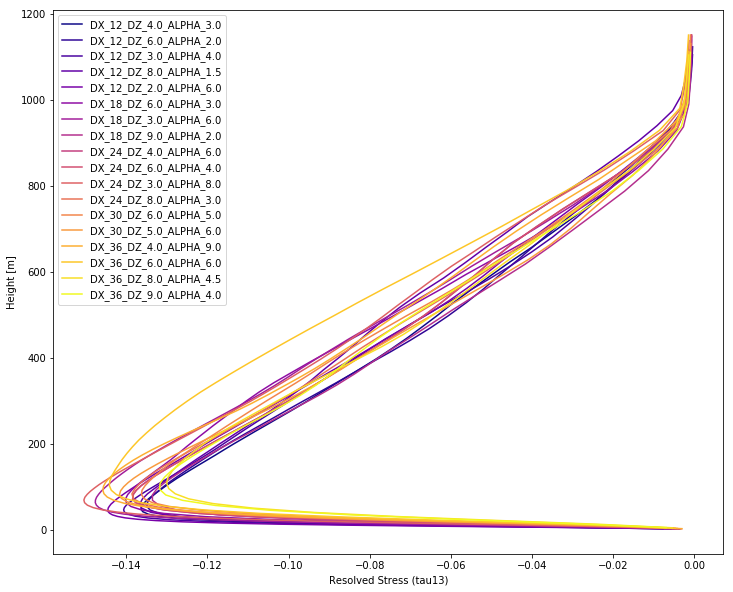

In [105]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, len(case)):
    ax.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{case[tt]}' )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
ax.legend()


(0.0, 200)

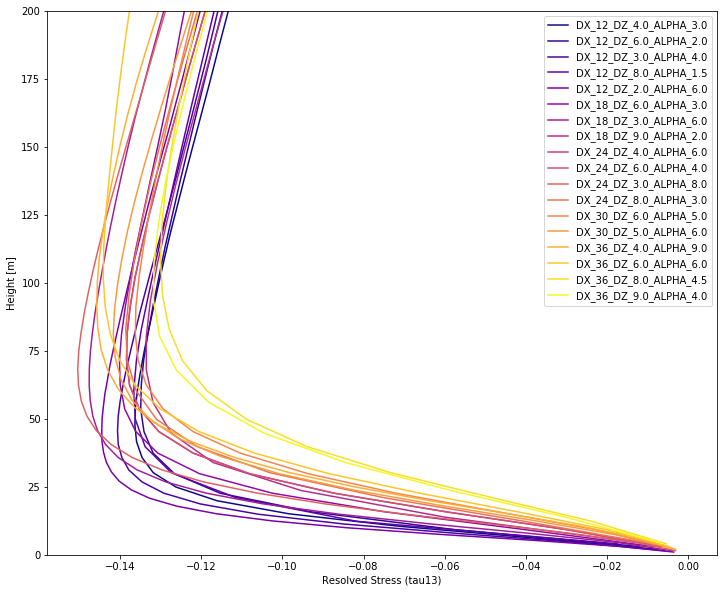

In [106]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, len(case)):
    ax.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{case[tt]}' )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
ax.legend()


ax.set_ylim([0.,200])

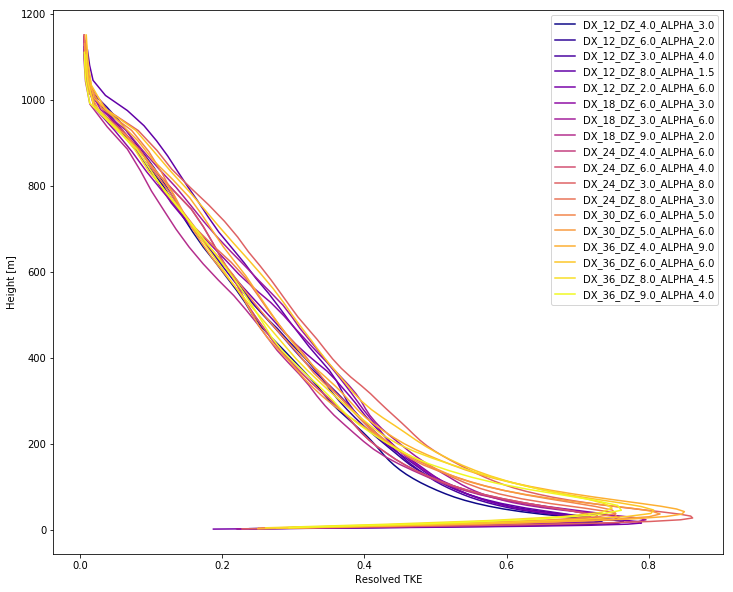

In [109]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(case)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{case[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

(0.0, 200)

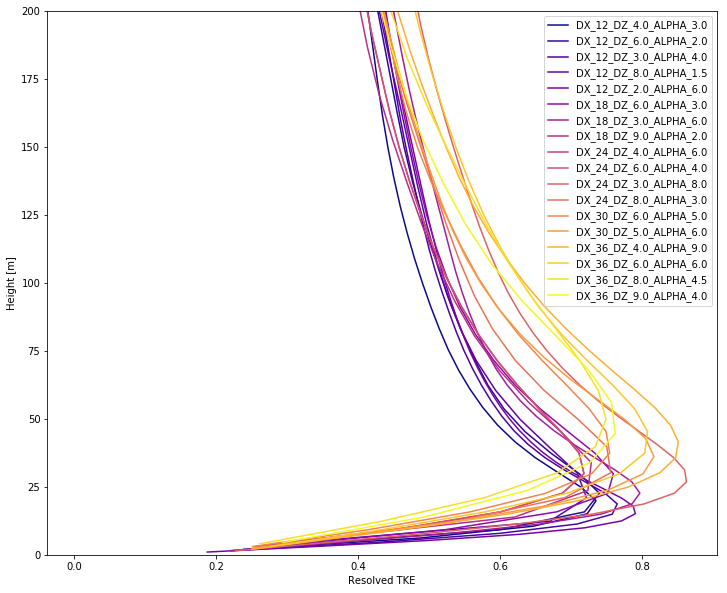

In [110]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(case)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{case[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

ax.set_ylim([0., 200])

### Spectra

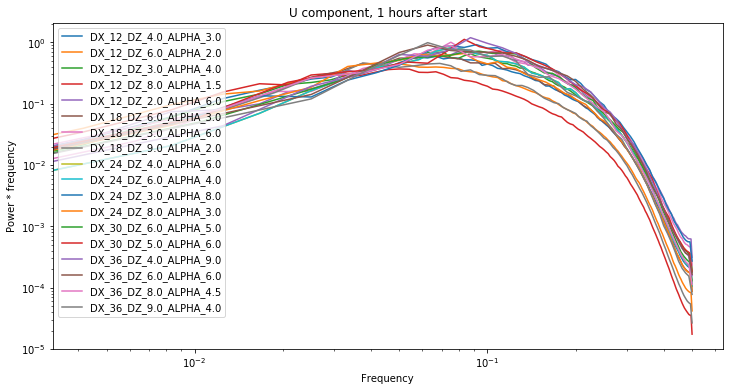

In [119]:
#Spectra after one hour a function of cases

f, ax  = plt.subplots(figsize = ( 12, 6) )

z_spectra=0 #first level

for tt in range(0, len(case)): 
    z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
    psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
    psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
    ax.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
            label = f'{case[tt]}' )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"U component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')
